In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

%reload_ext tensorboard

In [16]:
'''resize_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(32, 32),
    tf.keras.layers.Rescaling(1./255),
    #tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    #tf.keras.layers.RandomRotation(0.2),
])'''  

2022-12-07 15:24:15.885436: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


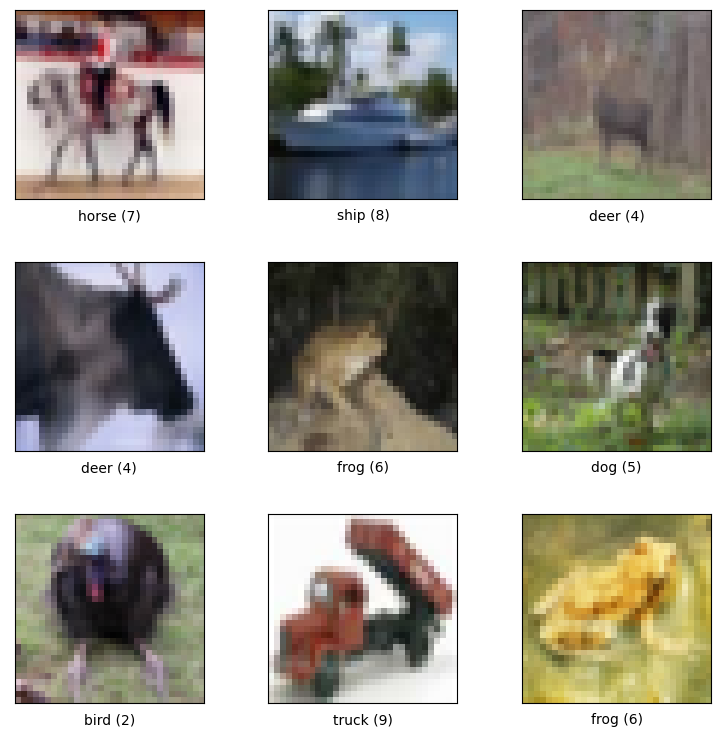

50000
50000
100000


'i = 0\nfor img in train_ds:\n    i += 1\nprint(i)'

In [17]:
# load the data
(train_ds, val_ds), ds_info = tfds.load('cifar10', split=['train', 'test'], 
                            shuffle_files=True, with_info=True)
# visualize a sample
tfds.show_examples(train_ds, ds_info)

# preprocess the data
one_hot = lambda x: tf.one_hot(x, 10)
augment_func = lambda x,y:(resize_rescale(x), y)
map_func = lambda x,y: (tf.cast(x, dtype=tf.float32)/255., # normalization
                            tf.cast(one_hot(y),tf.float32)) # make labels into one hot vectors
map_func_2 = lambda x: (x["image"],x["label"])
augment_ds = train_ds.map(map_func_2).map(map_func).map(augment_func)
train_ds = train_ds.map(map_func_2).map(map_func)
val_ds   = val_ds.map(map_func_2).map(map_func).cache()

i = 0
for img in augment_ds:
    i += 1
print(i)

i = 0
for img in train_ds:
    i += 1
print(i)
train_ds = train_ds.concatenate(augment_ds).cache()
i = 0
for img in train_ds:
    i += 1
print(i)

# prepare the datasets
batch_size = 32
train_ds = train_ds.shuffle(4096).batch(batch_size)
val_ds   = val_ds.shuffle(4096).batch(batch_size)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

'''i = 0
for img in train_ds:
    i += 1
print(i)'''

In [18]:
class ConvModel(tf.keras.Model):
    """
    The Convolutional Neural Network Model for the Classification of the CIFAR-10 dataset.

    It consists of 4 hidden layers and one output layer. The first 3 layers are convolutional,
    while the last hidden layer and the output layer are fully connected. On the output of
    each layer a Normalization and MaxPooling and Droput (apart from first layer) is performed.
    """
    def __init__(self):
        """
        A Function that initializes the super-class and the layers of the network.
        """
        super().__init__()

        # convolutional hidden layer 1 with normalization and pooling
        self.layer1 = tf.keras.Sequential()
        self.layer1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', 
                                               activation='relu', kernel_initializer='he_uniform'))
        self.layer1.add(tf.keras.layers.BatchNormalization())
        self.layer1.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))

        # convolutional hidden layer 3 with normalization, pooling and dropout
        self.layer2 = tf.keras.Sequential()
        self.layer2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', 
                                               activation='relu', kernel_initializer='he_uniform'))
        self.layer2.add(tf.keras.layers.BatchNormalization())
        self.layer2.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
        self.layer2.add(tf.keras.layers.Dropout(0.2))
        
        # convolutional hidden layer 3 with normalization and pooling
        self.layer3 = tf.keras.Sequential()
        self.layer3.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', 
                                               activation='relu', kernel_initializer='he_uniform'))
        self.layer3.add(tf.keras.layers.BatchNormalization())
        self.layer3.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
        self.layer2.add(tf.keras.layers.Dropout(0.2))

        # fully connected hidden layer 4 with flattening, normalization and dropout
        # by removing this layer the training time would decrease (number of parameters of the model would decrease significantly)
        # but with that also the performance decreases
        self.layer4 = tf.keras.Sequential()
        self.layer4.add(tf.keras.layers.Flatten())
        self.layer4.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
        self.layer4.add(tf.keras.layers.BatchNormalization())
        self.layer4.add(tf.keras.layers.Dropout(0.3))

        # fully connected output layer
        self.out = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x):
        """
        A Function that passes a signal through all layers of the network.

        Parameters:
            x (tf.Tensor): The ANN model to be trained.
        
        Returns:
            Output of the network
        """
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x) 
        x = self.out(x)
        return x

In [19]:
# instantiate and compile model with its hyperparameters
model = ConvModel()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# build the model and show summary
model(tf.keras.Input((32,32,3)));
model.summary()

Model: "conv_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 16, 16, 32)        2560      
                                                                 
 sequential_7 (Sequential)   (None, 8, 8, 64)          18752     
                                                                 
 sequential_8 (Sequential)   (None, 4, 4, 128)         74368     
                                                                 
 sequential_9 (Sequential)   (None, 128)               262784    
                                                                 
 dense_3 (Dense)             multiple                  1290      
                                                                 
Total params: 359,754
Trainable params: 359,050
Non-trainable params: 704
_________________________________________________________________


In [20]:
import datetime

def create_file_writers():
    """
    A function to create the log file writers for the Tensorboard.
    
    Returns:
        The log file writers for the training validation metrics respectively.
    """

    # Define where to save the log
    config_name= "config_name"
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_path = f"logs/{config_name}/{current_time}/train"
    val_log_path = f"logs/{config_name}/{current_time}/val"
    
    return tf.summary.create_file_writer(train_log_path), tf.summary.create_file_writer(val_log_path)

In [21]:
import pprint
import tqdm

def training_loop(model, train_ds, val_ds, epochs):
    """
    A Function that trains a model on the training and validation data.

    It creates file writers to save the metrics for visualization 
    with the Tensorboard. Then it iterates over all epochs, performs
    a forward and backwardspass of the model with the training 
    and validation dataset and saves the respective performance metrics.

    Parameters:
        model (Model): The ANN model to be trained.
        train_ds (PrefetchDataset): The preprocessed training dataset.
        val_ds (PrefetchDataset): The preprocessed validation dataset.
    """
    # create file writers
    train_summary_writer, val_summary_writer = create_file_writers()

    for epoch in range(epochs):
        print(f"Epoch {epoch}:")
        
        # Training:
        for data in tqdm.tqdm(train_ds, position=0, leave=True):
            metrics = model.train_step(data)
            
            # logging the validation metrics to the log file which is used by tensorboard
            with train_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])
        
        model.reset_metrics()    
        
        # Validation:
        for data in val_ds:
            metrics = model.test_step(data)
        
            # logging the validation metrics to the log file which is used by tensorboard
            with val_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
                    
        print([f"val_{key}: {value.numpy()}\n" for (key, value) in metrics.items()])

        model.reset_metrics()

In [22]:
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 525), started 3 days, 1:31:52 ago. (Use '!kill 525' to kill it.)

In [23]:
# run the training loop 
training_loop(model=model, 
              train_ds=train_ds, 
              val_ds=val_ds, 
              epochs=15
)
print("Training finished.")

Epoch 0:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [03:05<00:00, 16.87it/s]


['loss: 1.3926705121994019', 'accuracy: 0.510670006275177']
['val_loss: 380.8900146484375\n', 'val_accuracy: 0.10040000081062317\n']
Epoch 1:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [03:05<00:00, 16.80it/s]


['loss: 1.0842055082321167', 'accuracy: 0.6180800199508667']
['val_loss: 535.236328125\n', 'val_accuracy: 0.11670000106096268\n']
Epoch 2:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [03:15<00:00, 15.97it/s]


['loss: 0.9809983372688293', 'accuracy: 0.6591299772262573']
['val_loss: 296.54931640625\n', 'val_accuracy: 0.11810000240802765\n']
Epoch 3:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [03:13<00:00, 16.17it/s]


['loss: 0.904874861240387', 'accuracy: 0.6845200061798096']
['val_loss: 431.04254150390625\n', 'val_accuracy: 0.11010000109672546\n']
Epoch 4:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [03:06<00:00, 16.74it/s]


['loss: 0.8421908020973206', 'accuracy: 0.706250011920929']
['val_loss: 2266.619384765625\n', 'val_accuracy: 0.10570000112056732\n']
Epoch 5:


 14%|███████████████████████████▊                                                                                                                                                                         | 441/3125 [00:27<02:46, 16.15it/s]


KeyboardInterrupt: 